Predictions and simulations project

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import statsmodels.formula.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
    

from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

In [2]:
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

In [3]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


<AxesSubplot:>

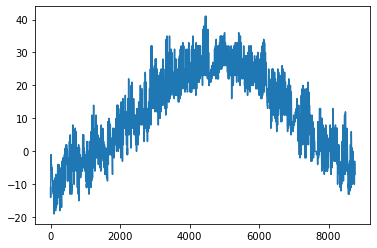

In [4]:
df['TEMP'][0:365*24].plot()

<AxesSubplot:>

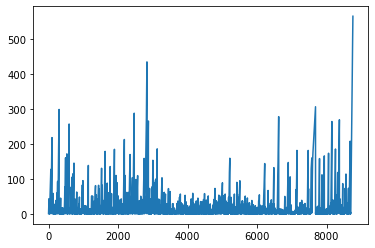

In [5]:
df['Iws'][0:365*24].plot()

In [6]:
df.dtypes

No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

In [7]:
df.rename({"pm2.5": "pm"}, axis=1, inplace=True)

<AxesSubplot:>

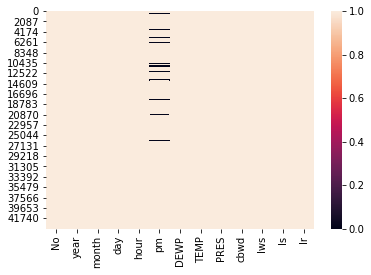

In [8]:
# co robimy z NaN'ami?
sns.heatmap(df.isna()==False)

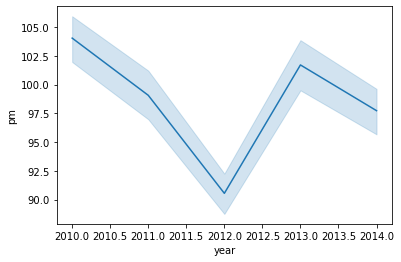

In [9]:
dfplot = sns.lineplot(x = 'year', y = 'pm', data = df)

In [10]:
datetime = df[['year', 'month', 'day', 'hour']]
datetime

,year,month,day,hour
0,2010,1,1,0
1,2010,1,1,1
2,2010,1,1,2
3,2010,1,1,3
4,2010,1,1,4
...,...,...,...,...
43819,2014,12,31,19
43820,2014,12,31,20
43821,2014,12,31,21
43822,2014,12,31,22


In [11]:
df['Datetime'] = pd.to_datetime(datetime)

In [12]:
df.head()

,No,year,month,day,hour,pm,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,Datetime
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [13]:
# set up datetime column as index and delete nulls
df.index = df['Datetime']
del df['Datetime']
del df['No']
df.dropna(inplace=True)

In [14]:
df["pm"] = df["pm"].astype("int64")
df["TEMP"] = df["TEMP"].astype("int64")
df["PRES"] = df["PRES"].astype("int64")
df["Iws"] = df["Iws"].astype("int64")

43824 - 41757 = 2067 Na's went delet

In [15]:
%%markdown
## Data Exploration

## Data Exploration


In [16]:
import calendar
# Plot PM 2.5 level by MONTH
plt.figure(figsize= (10,10))
sns.boxplot(x="month", y="pm", data=df, showfliers=False)
plt.xlabel('Month')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Month')
plt.xticks(range(0,12), calendar.month_abbr[1:13])

NameError: name 'plt' is not defined

ValueError: The number of FixedLocator locations (31), usually from a call to set_ticks, does not match the number of ticklabels (6).

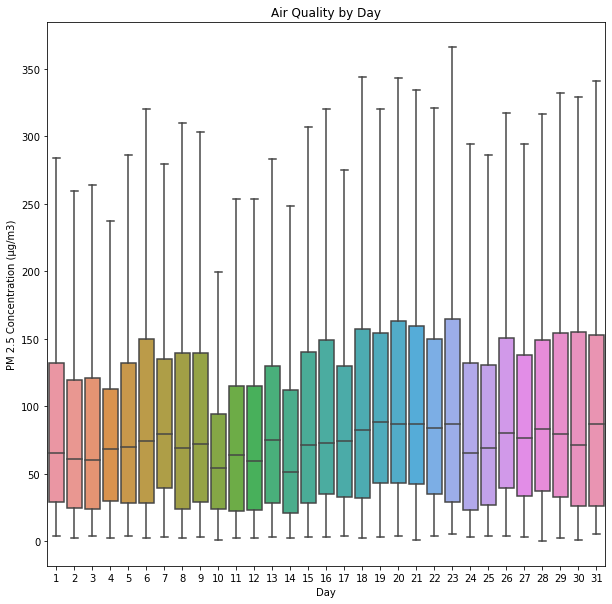

In [ ]:
# Plot PM 2.5 level by DAY OF THE WEEK
plt.figure(figsize= (10,10))
sns.boxplot(x="day", y="pm", data=df, showfliers=False)
plt.xlabel('Day')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Day')
plt.xticks(range(0,31), calendar.day_abbr[1:32])

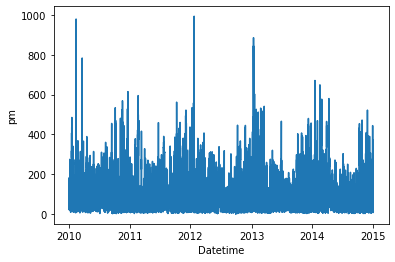

In [17]:
# plot the dependent variable in the whole period
dfplot = sns.lineplot(x = 'Datetime', y = 'pm', data = df)

<AxesSubplot:xlabel='Datetime'>

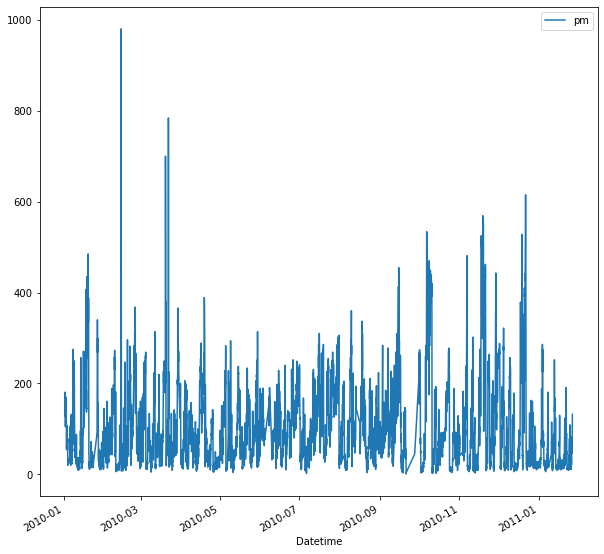

In [18]:
# plot the first year to search for monthly seasonality
df[0:24*30*12][['pm']].plot(figsize=(10,10))

<AxesSubplot:xlabel='Datetime'>

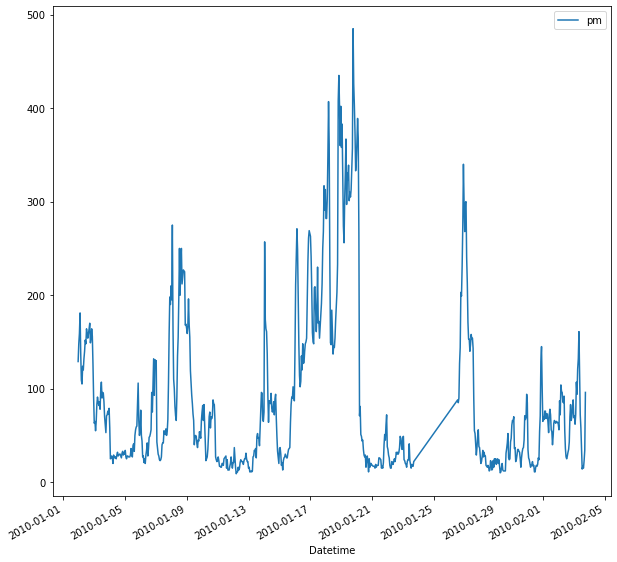

In [19]:
# plot the first 10 days to search for daily seasonality
df[0:24*30][['pm']].plot(figsize=(10,10))

<AxesSubplot:xlabel='Datetime'>

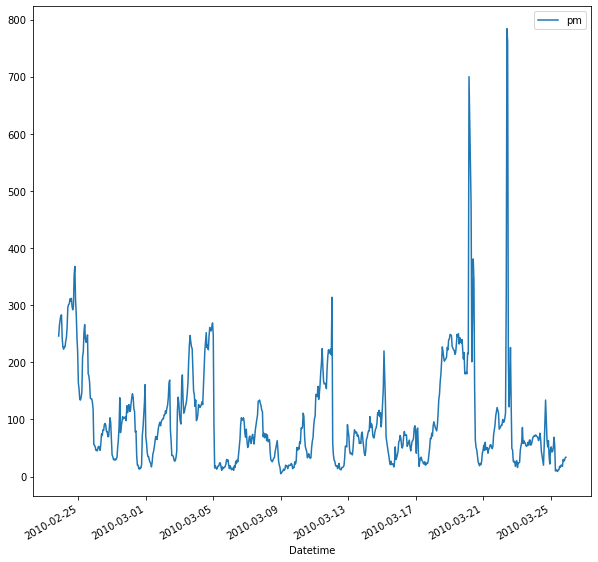

In [20]:
df[50*24:50*24+24*30][['pm']].plot(figsize=(10,10))

<AxesSubplot:xlabel='Datetime'>

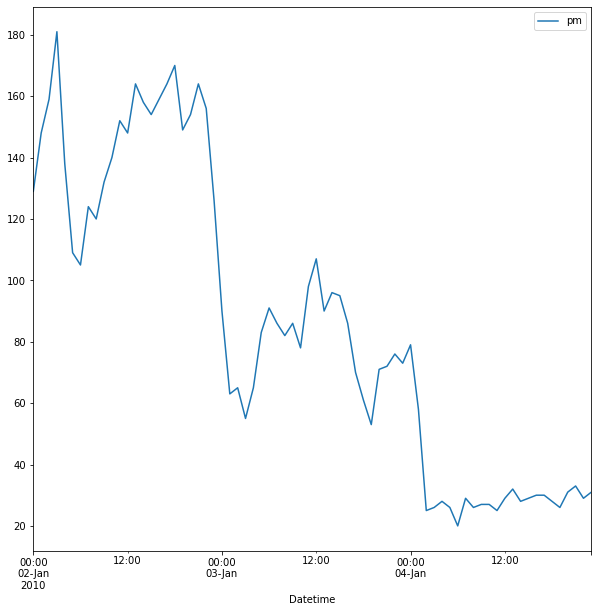

In [21]:
# plot the first month to search for hourly seasonality
df[0:24*3][['pm']].plot(figsize=(10,10))

<AxesSubplot:xlabel='month'>

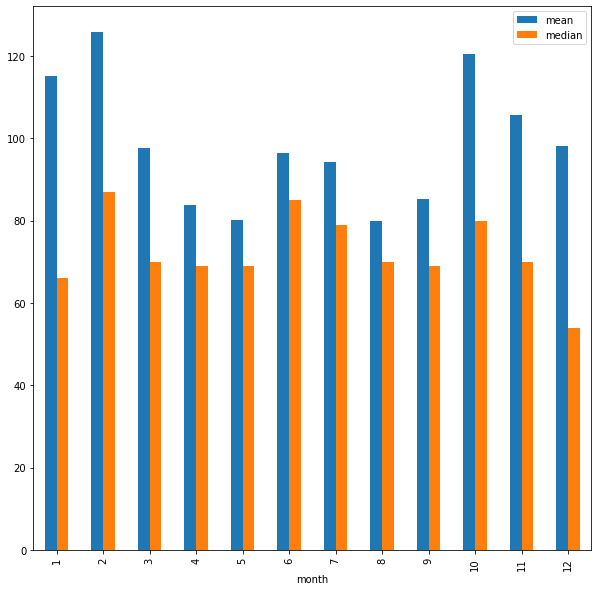

In [22]:
df.groupby('month')['pm'].aggregate(['mean', 'median']).plot(kind="bar", figsize=(10,10))

<AxesSubplot:xlabel='hour'>

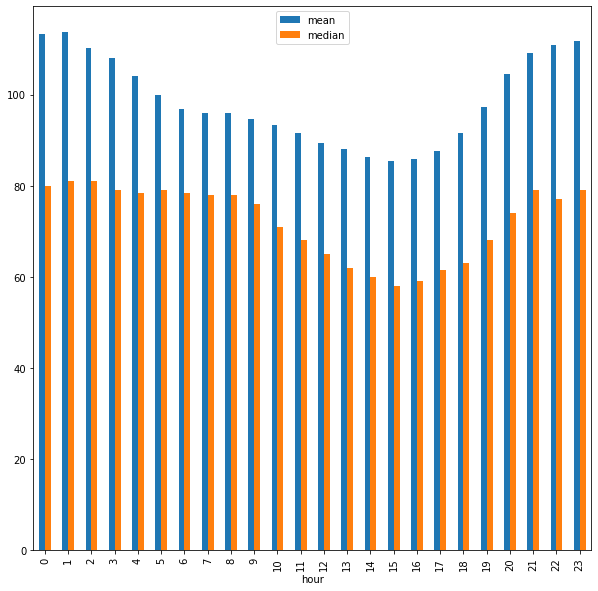

In [23]:
df.groupby('hour')['pm'].aggregate(['mean', 'median']).plot(kind="bar", figsize=(10,10))

In [24]:
%%markdown
## Feature Engineering

## Feature Engineering


In [25]:
# create a season variable with winter, spring, summer, fall instead of individual months

def season(month):
    if month in (4,5,6):
        return "spring"
    elif month in (7,8,9):
        return "summer"
    elif month in (10,11,12):
        return "fall"
    else:
        return "winter"
        
def season2(month):
    if month in (3, 4,5,6, 7, 8, 9):
        return "warm"
    elif month in (10, 11, 12 , 1, 2):
        return "cold"

df['season'] = df['month'].apply(season2)

In [26]:
# create a day time variable that aggregates hours into specific times of day

def day_time(hour):
    if hour in (20, 21, 22, 23, 0, 1, 2, 3, 4):
        return "night"
    elif hour in(5, 6, 7, 8, 9, 10, 11, 12):
        return "morning"
    else:
        return "afternoon"

df['day_time'] = df['hour'].apply(day_time)

In [27]:
# create a Trend variable to allow for time-series regression
df['Trend'] = np.arange(1, len(df) + 1)

# create a log pm2.5 variable
df['log_pm'] = np.log(df['pm']+1)

# create a lag variable 
df['log_lag_pm'] = df['log_pm'].shift(-1)

In [28]:
%%markdown
## Creating the Regression <- only with time aspect, without independent variables

## Creating the Regression <- only with time aspect, without independent variables


In [29]:
# split the dataset into train and test to allow for in and out of sample forecasts
df_sample = df[df.index < '2014-01-01']
df_forecast = df[df.index >= '2014-01-01']

<AxesSubplot:xlabel='Datetime'>

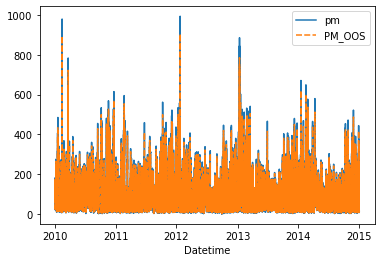

In [30]:
df_ft = df[0:-716]

model = sm.ols(formula="log_pm ~ Trend + log_lag_pm + C(season) + C(day_time)", data=df_ft)
results = model.fit()
results.summary()

results.predict(df)

df['PM_OOS'] = np.exp(results.predict(df))
dfplot = df.filter(['pm', 'PM_OOS'])
sns.lineplot(data=dfplot)

In [31]:
from scipy.stats import spearmanr

y_in = df.pm[0:-716]

y_out = df.pm.tail(716)

pred_in = df.PM_OOS[0:-716]

pred_out = df.PM_OOS.tail(716)
actual = df.pm.tail(716)

# putting the objects into lists

ys = [y_in, y_out]

preds = [pred_in, pred_out]

descr = ['IN', 'OUT']

In [32]:
res = pd.DataFrame(actual)
res['pred'] = pred_out


<AxesSubplot:xlabel='Datetime'>

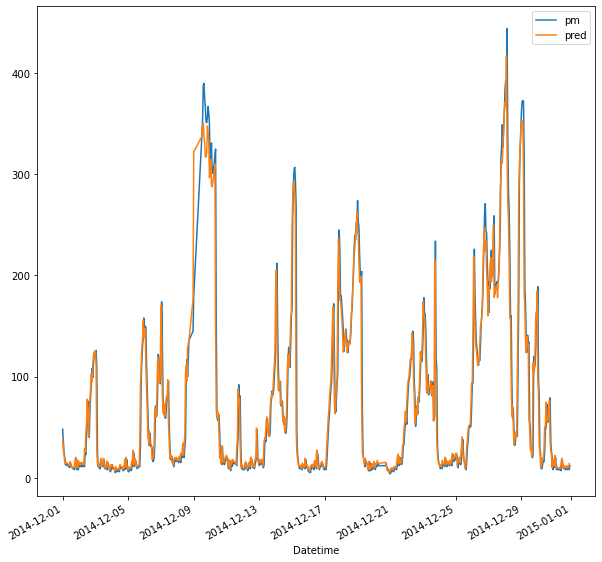

In [33]:
res[['pm', 'pred']].plot(figsize=(10,10))

<AxesSubplot:xlabel='Datetime'>

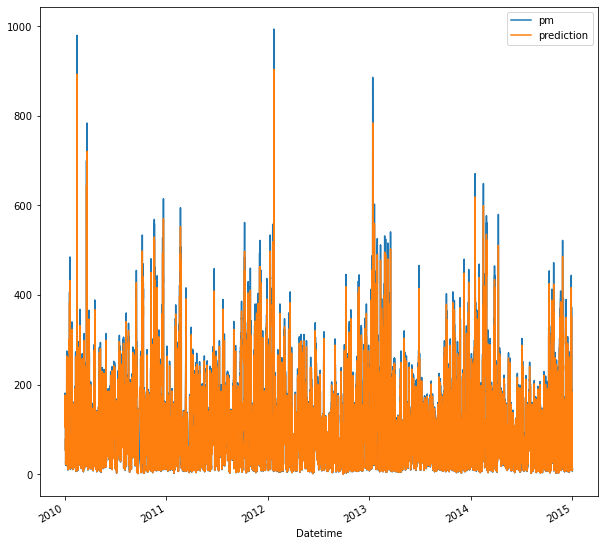

In [34]:
df['prediction'] = np.exp(results.predict(df)) - 1
df[['pm', 'prediction']].plot(figsize=(10,10))

In [35]:
# create a model with trend, month, day and hour variables
model = sm.ols(formula="log_pm ~ Trend + log_lag_pm + C(season) + C(day_time)", data=df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_pm   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 1.022e+05
Date:                Tue, 14 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:13:33   Log-Likelihood:                -5541.4
No. Observations:               41756   AIC:                         1.109e+04
Df Residuals:                   41750   BIC:                         1.115e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1337      0.007     19.755      0.000       0.120       0.147
C(season)[T.warm]         -0.0011      0.003     -0.389      0.697      -0.006       0.004
C(day_time)[T.morning]     0.0525      0.003     15.312      0.000       0.046       0.059
C(day_time)[T.night]       0.0507      0.003     15.135      0.000       0.044       0.057
Trend                  -1.199e-07   1.12e-07     -1.068      0.285    -3.4e-07       1e-07
log_lag_pm                 0.9599      0.001    710.527      0.000       0.957       0.963
==============================================================================
Omnibus:                    10220.759   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           224352.435
Skew:                           0.650   Prob(JB):                         0.00
Kurtosis:                      14.281   Cond. No.                     1.25e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
%%markdown
### In-The-Sample Prediction

### In-The-Sample Prediction


In [37]:
# create predictions and save to a variable
df['pm_forecast_ITS'] = np.exp(res.predict(df_sample)) - 1

<AxesSubplot:xlabel='Datetime'>

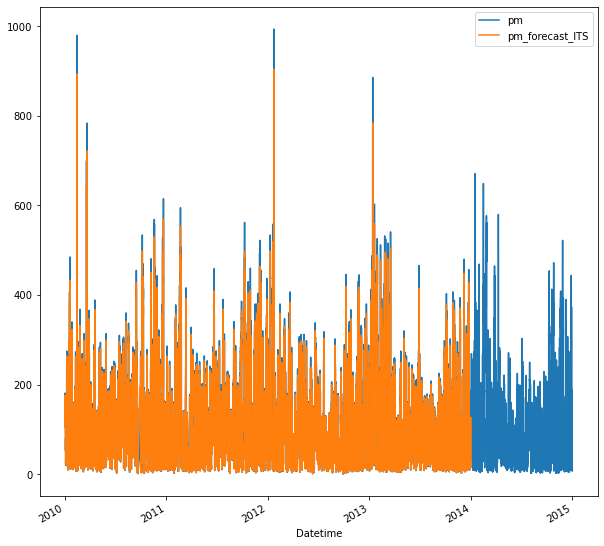

In [38]:
# plot predictions and actual values (whole time period)
df.filter(['pm', 'pm_forecast_ITS']).plot(figsize=(10,10))

<AxesSubplot:xlabel='Datetime'>

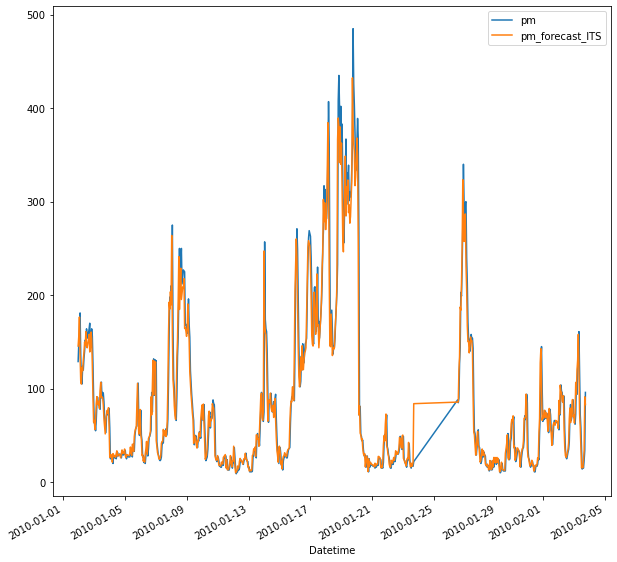

In [39]:
# plot predictions and actual values (first month)
df[0:24*30].filter(['pm', 'pm_forecast_ITS']).plot(figsize=(10,10))

In [40]:
%%markdown
### Out-Of-Sample Prediction

### Out-Of-Sample Prediction


In [41]:
df['pm_forecast_OOS'] = np.exp(res.predict(df_forecast)) + 1

<AxesSubplot:xlabel='Datetime'>

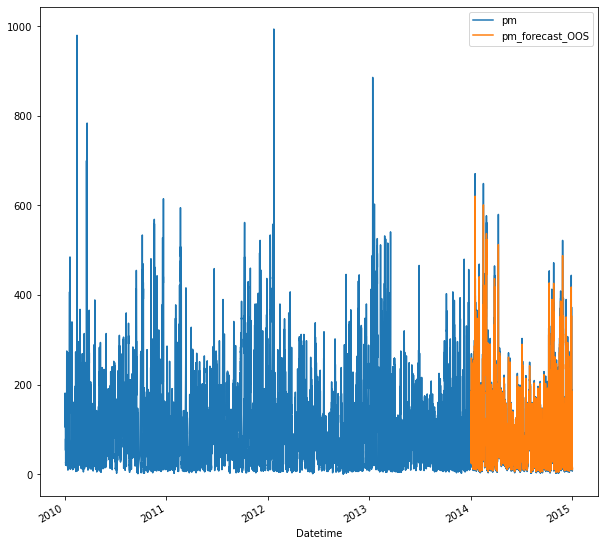

In [42]:
# plot out of sample predictions and actual values (whole time period)
df.filter(['pm', 'pm_forecast_OOS']).plot(figsize=(10,10))

<AxesSubplot:xlabel='Datetime'>

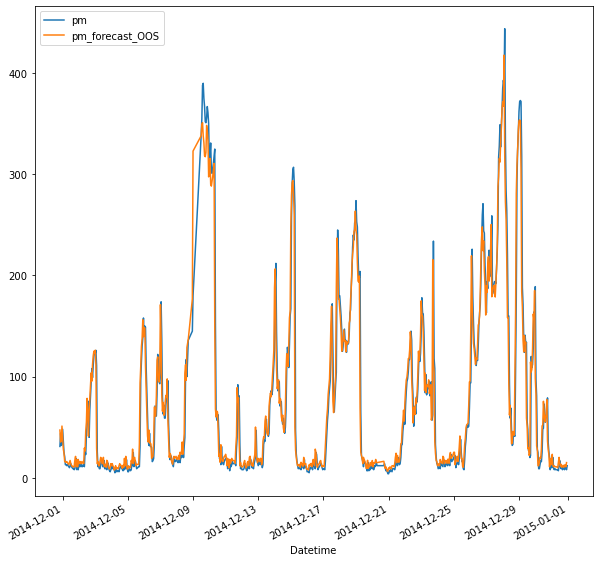

In [43]:
# plot out of sample predictions and actual values (first month)
df[len(df) - 24*30:len(df)].filter(['pm', 'pm_forecast_OOS']).plot(figsize=(10,10))

In [44]:
%%markdown
## Creating Regression <- with independent variables

## Creating Regression <- with independent variables


In [45]:
# look at correlation between the independent variables and the independent one
df.corr()['pm']

year              -0.014690
month             -0.024069
day                0.082788
hour              -0.023116
pm                 1.000000
DEWP               0.171423
TEMP              -0.090533
PRES              -0.047282
Iws               -0.248389
Is                 0.019266
Ir                -0.051369
Trend             -0.018218
log_pm             0.866939
log_lag_pm         0.839570
PM_OOS             0.964740
prediction         0.964740
pm_forecast_ITS    0.962713
pm_forecast_OOS    0.972126
Name: pm, dtype: float64

In [46]:
model2 = sm.ols(formula="log_pm ~ Trend + log_lag_pm + C(season)+ C(day_time) + DEWP + Iws", data=df_sample)
res2 = model.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_pm   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 1.022e+05
Date:                Tue, 14 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:13:36   Log-Likelihood:                -5541.4
No. Observations:               41756   AIC:                         1.109e+04
Df Residuals:                   41750   BIC:                         1.115e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1337      0.007     19.755      0.000       0.120       0.147
C(season)[T.warm]         -0.0011      0.003     -0.389      0.697      -0.006       0.004
C(day_time)[T.morning]     0.0525      0.003     15.312      0.000       0.046       0.059
C(day_time)[T.night]       0.0507      0.003     15.135      0.000       0.044       0.057
Trend                  -1.199e-07   1.12e-07     -1.068      0.285    -3.4e-07       1e-07
log_lag_pm                 0.9599      0.001    710.527      0.000       0.957       0.963
==============================================================================
Omnibus:                    10220.759   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           224352.435
Skew:                           0.650   Prob(JB):                         0.00
Kurtosis:                      14.281   Cond. No.                     1.25e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
%%markdown
### Independent variables do not add any value to this model

### Independent variables do not add any value to this model


In [48]:
%%markdown
## Naive Forecast

## Naive Forecast


<AxesSubplot:xlabel='Datetime'>

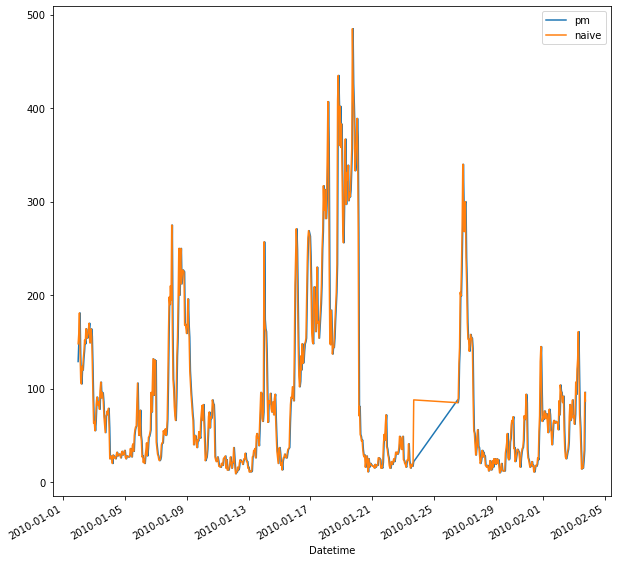

In [49]:
df['naive'] = df['pm'].shift(-1)


df[['pm', 'naive']][0:24*30].plot(figsize=(10,10))


In [50]:
df['prediction'] = np.exp(res.predict(df)) + 1

In [51]:
df_clean = df[['pm', 'prediction', 'naive']].dropna()

In [52]:
naive_rmse = np.sqrt(mean_squared_error(df_clean['pm'], df_clean['naive']))
model_rmse = np.sqrt(mean_squared_error(df_clean['pm'], df_clean['prediction']))

print("Naive RMSE: {}".format(naive_rmse))
print("Model RMSE: {}".format(model_rmse))

Naive RMSE: 24.524880282070487
Model RMSE: 24.429391961796664


In [53]:
df

,year,month,day,hour,pm,DEWP,TEMP,PRES,cbwd,Iws,...,season,day_time,Trend,log_pm,log_lag_pm,PM_OOS,prediction,pm_forecast_ITS,pm_forecast_OOS,naive
Datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,129,-16,-4,1020,SE,1,...,cold,night,1,4.867534,5.003946,146.471944,147.577643,145.577643,NaN,148.0
2010-01-02 01:00:00,2010,1,2,1,148,-15,-4,1020,SE,2,...,cold,night,2,5.003946,5.075174,156.834898,157.949563,155.949563,NaN,159.0
2010-01-02 02:00:00,2010,1,2,2,159,-11,-5,1021,SE,3,...,cold,night,3,5.075174,5.204007,177.476731,178.609539,176.609539,NaN,181.0
2010-01-02 03:00:00,2010,1,2,3,181,-7,-5,1022,SE,5,...,cold,night,4,5.204007,4.934474,137.024304,138.121896,136.121896,NaN,138.0
2010-01-02 04:00:00,2010,1,2,4,138,-7,-5,1022,SE,6,...,cold,night,5,4.934474,4.700480,109.462876,110.537408,108.537408,NaN,109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,2014,12,31,19,8,-23,-2,1034,NW,231,...,cold,afternoon,41753,2.197225,2.397895,11.388170,12.363472,NaN,12.363472,10.0
2014-12-31 20:00:00,2014,12,31,20,10,-22,-3,1034,NW,237,...,cold,night,41754,2.397895,2.397895,11.969849,12.954052,NaN,12.954052,10.0
2014-12-31 21:00:00,2014,12,31,21,10,-22,-3,1034,NW,242,...,cold,night,41755,2.397895,2.197225,9.872957,10.859662,NaN,10.859662,8.0


## Kinda bad model, worth to mention 

In [54]:

model = sm.ols(formula="log_pm ~ Trend + C(year) + C(month) + C(hour) + DEWP + TEMP + PRES + C(cbwd) + Iws + Is + Ir", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_pm   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     1018.
Date:                Tue, 14 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:13:45   Log-Likelihood:                -43288.
No. Observations:               41757   AIC:                         8.667e+04
Df Residuals:                   41708   BIC:                         8.710e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          25.5522      0.724     35.273      0.000      24.132      26.972
C(year)[T.2011]    -1.3471      0.120    -11.227      0.000      -1.582      -1.112
C(year)[T.2012]    -2.7700      0.244    -11.374      0.000      -3.247      -2.293
C(year)[T.2013]    -3.9423      0.370    -10.660      0.000      -4.667      -3.217
C(year)[T.2014]    -5.3843      0.500    -10.777      0.000      -6.363      -4.405
C(month)[T.2]      -0.2972      0.020    -15.076      0.000      -0.336      -0.259
C(month)[T.3]      -0.7398      0.028    -26.571      0.000      -0.794      -0.685
C(month)[T.4]      -1.3842      0.039    -35.591      0.000      -1.460      -1.308
C(month)[T.5]      -2.0622      0.051    -40.832      0.000      -2.161      -1.963
C(month)[T.6]      -2.8794      0.061    -47.047      0.000      -2.999      -2.759
C(month)[T.7]      -3.3125      0.072    -46.322      0.000      -3.453      -3.172
C(month)[T.8]      -3.4414      0.080    -42.849      0.000      -3.599      -3.284
C(month)[T.9]      -3.0774      0.088    -35.009      0.000      -3.250      -2.905
C(month)[T.10]     -2.4144      0.096    -25.111      0.000      -2.603      -2.226
C(month)[T.11]     -1.8055      0.106    -17.107      0.000      -2.012      -1.599
C(month)[T.12]     -1.4301      0.116    -12.359      0.000      -1.657      -1.203
C(hour)[T.1]       -0.0319      0.023     -1.376      0.169      -0.077       0.014
C(hour)[T.2]       -0.0575      0.023     -2.478      0.013      -0.103      -0.012
C(hour)[T.3]       -0.0833      0.023     -3.589      0.000      -0.129      -0.038
C(hour)[T.4]       -0.1191      0.023     -5.117      0.000      -0.165      -0.073
C(hour)[T.5]       -0.1451      0.023     -6.220      0.000      -0.191      -0.099
C(hour)[T.6]       -0.1741      0.023     -7.464      0.000      -0.220      -0.128
C(hour)[T.7]       -0.1339      0.023     -5.754      0.000      -0.180      -0.088
C(hour)[T.8]       -0.0543      0.023     -2.334      0.020      -0.100      -0.009
C(hour)[T.9]        0.0280      0.023      1.200      0.230      -0.018       0.074
C(hour)[T.10]       0.0987      0.024      4.184      0.000       0.052       0.145
C(hour)[T.11]       0.1252      0.024      5.249      0.000       0.078       0.172
C(hour)[T.12]       0.1391      0.024      5.785      0.000       0.092       0.186
C(hour)[T.13]       0.1502      0.024      6.214      0.000       0.103       0.198
C(hour)[T.14]       0.1278      0.024      5.255      0.000       0.080       0.175
C(hour)[T.15]       0.1123      0.024      4.614      0.000       0.065       0.160
C(hour)[T.16]       0.0789      0.024      3.252      0.001       0.031       0.126
C(hour)[T.17]       0.0402      0.024      1.673      0.094      -0.007       0.087
C(hour)[T.18]       0.0195      0.024      0.822      0.411

<AxesSubplot:xlabel='Datetime'>

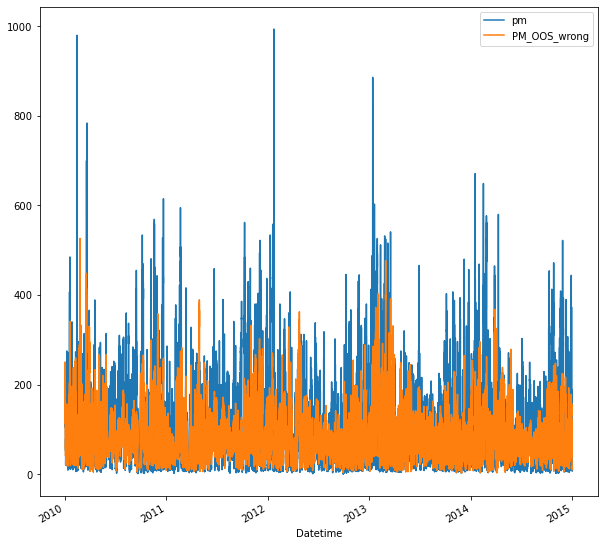

In [55]:
results.predict(df)
df['PM_OOS_wrong'] = np.exp(results.predict(df))
dfplot = df.filter(['pm', 'PM_OOS_wrong'])
dfplot[['pm', 'PM_OOS_wrong']].plot(figsize=(10,10))

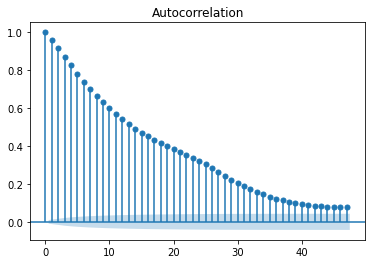

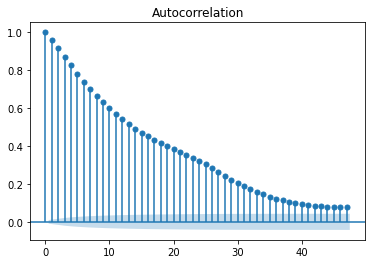

In [56]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.log_pm)


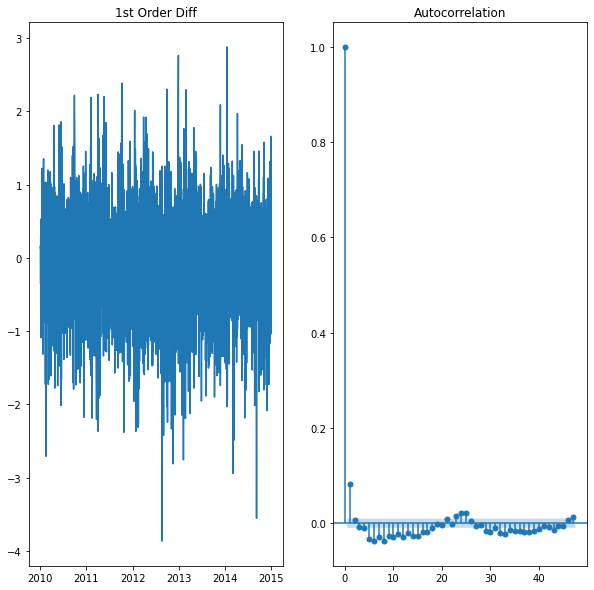

In [57]:
import matplotlib.pyplot as plt

f = plt.figure(figsize= (10,10))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Diff')
ax1.plot(df.log_pm.diff())

ax2 = f.add_subplot(122)
plot_acf(df.log_pm.diff().dropna(), ax= ax2)
plt.show()

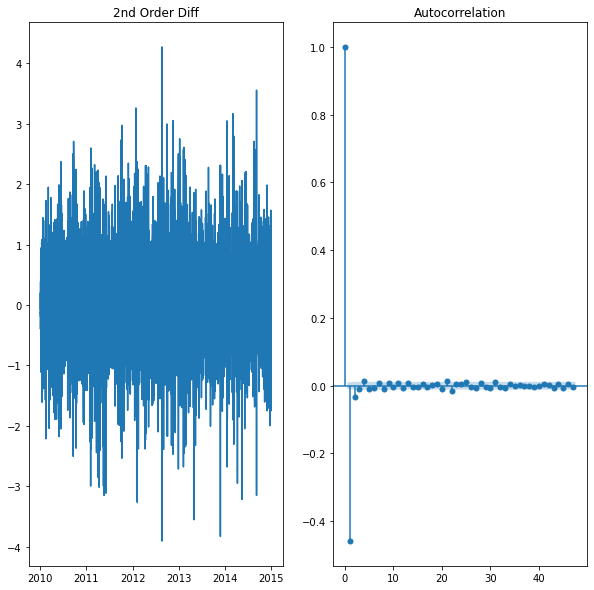

In [58]:
f = plt.figure(figsize= (10, 10))
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Diff')
ax1.plot(df.log_pm.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(df.log_pm.diff().diff().dropna(), ax = ax2)
plt.show()

In [59]:
from statsmodels.tsa.arima_model import ARIMA
df["log_pm"] = df["log_pm"].astype("int64")
df.dtypes

year                 int64
month                int64
day                  int64
hour                 int64
pm                   int64
DEWP                 int64
TEMP                 int64
PRES                 int64
cbwd                object
Iws                  int64
Is                   int64
Ir                   int64
season              object
day_time            object
Trend                int32
log_pm               int64
log_lag_pm         float64
PM_OOS             float64
prediction         float64
pm_forecast_ITS    float64
pm_forecast_OOS    float64
naive              float64
PM_OOS_wrong       float64
dtype: object

In [60]:
dftest = df.filter(['pm', 'log_pm', 'log_lag_pm'])

arima_model = ARIMA(dftest.pm, order=(2,0,1))
model  = arima_model.fit(disp=0)
print(model.summary())

c:\Users\mi.martowicz\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\Users\mi.martowicz\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associ

MemoryError: Unable to allocate 13.0 GiB for an array with shape (41703, 41703) and data type float64

In [ ]:
arima_model = ARIMA(dftest.pm, order=(2,1,1))
model  = arima_model.fit(disp=0)
print(model.summary())

e:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
e:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will b

                             ARIMA Model Results                              
Dep. Variable:                   D.pm   No. Observations:                41756
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -191699.249
Method:                       css-mle   S.D. of innovations             23.854
Date:                Tue, 14 Jun 2022   AIC                         383408.498
Time:                        13:59:11   BIC                         383451.695
Sample:                             1   HQIC                        383422.143
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.62e-05      0.002      0.033      0.974      -0.004       0.005
ar.L1.D.pm     1.1493      0.005    239.035      0.000       1.140       1.159
ar.L2.D.pm    -0.1928      0.005    -40.095      0.0

In [ ]:
arima_model = ARIMA(dftest.pm, order=(2,2,1))
model  = arima_model.fit(disp=0)
print(model.summary())

e:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
e:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will b

                             ARIMA Model Results                              
Dep. Variable:                  D2.pm   No. Observations:                41755
Model:                 ARIMA(2, 2, 1)   Log Likelihood             -192171.186
Method:                       css-mle   S.D. of innovations             24.126
Date:                Tue, 14 Jun 2022   AIC                         384352.371
Time:                        14:23:55   BIC                         384395.569
Sample:                             2   HQIC                        384366.017
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.015e-07   1.13e-05     -0.018      0.986   -2.24e-05     2.2e-05
ar.L1.D2.pm     0.1806      0.005     36.967      0.000       0.171       0.190
ar.L2.D2.pm    -0.0560      0.005    -11.453    

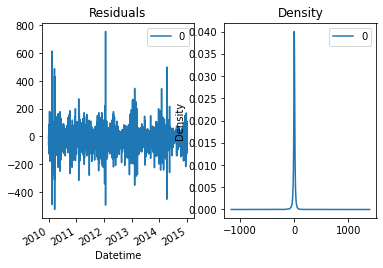

In [ ]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

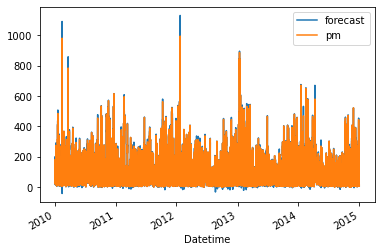

In [ ]:
# Actual vs Fitted
model.plot_predict(dynamic=False)
plt.show()

In [ ]:
#arima_model = ARIMA(dftest.log_pm, order=(2,1,2))
#model  = arima_model.fit(disp=0)
#print(model.summary())

In [ ]:
dfarima = df.filter(['pm', 'log_pm', 'log_lag_pm'])
dfarima['log_lag_pm'] = np.exp(dfarima['log_lag_pm'])
dfarima = dfarima.dropna()
dfarima

,pm,log_pm,log_lag_pm
Datetime,,,
2010-01-02 00:00:00,129,4,149.0
2010-01-02 01:00:00,148,5,160.0
2010-01-02 02:00:00,159,5,182.0
2010-01-02 03:00:00,181,5,139.0
2010-01-02 04:00:00,138,4,110.0
...,...,...,...
2014-12-31 18:00:00,10,2,9.0
2014-12-31 19:00:00,8,2,11.0
2014-12-31 20:00:00,10,2,11.0


In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test


train = dfarima.pm[:-10439]
test = dfarima.pm.tail(10439)

In [ ]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

e:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
e:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will b

                             ARIMA Model Results                              
Dep. Variable:           D.log_lag_pm   No. Observations:                31316
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -144837.611
Method:                       css-mle   S.D. of innovations             24.683
Date:                Tue, 14 Jun 2022   AIC                         289683.222
Time:                        14:50:11   BIC                         289716.630
Sample:                             1   HQIC                        289693.919
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0013      0.162      0.008      0.993      -0.316       0.319
ar.L1.D.log_lag_pm    -0.1402      0.026     -5.476      0.000      -0.190      -0.090
ma.L1.D.log_lag_pm  

e:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


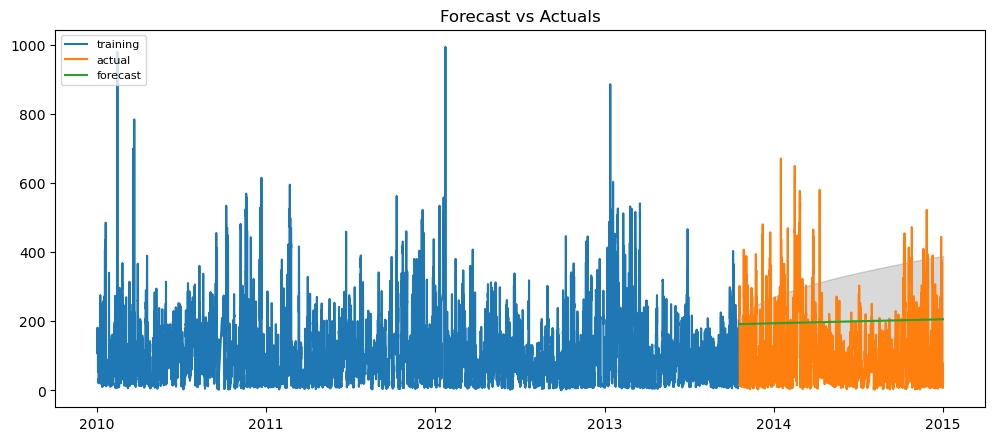

In [ ]:
fc, se, conf = fitted.forecast(10439, alpha=0.95)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()